# Description

The idea of this notebook is to explore a simple OLS model (Ordinary Least Squares) to associate an LV (gene weights) with a trait (gene z-scores). Since predicted gene expression is correlated, especially among adjacent genes, a simple OLS model is expected to fail by having high type I errors.

# Modules

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
from scipy import stats
from statsmodels.graphics.gofplots import qqplot_2samples
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import conf
from data.recount2 import LVAnalysis

# Settings

In [2]:
N_PHENOTYPES = 1000
N_LVS = 987

In [3]:
INPUT_DIR = conf.RESULTS["GLS_NULL_SIMS"] / "phenoplier"
display(INPUT_DIR)

PosixPath('/opt/data/results/gls/null_sims/phenoplier')

# Load MultiXcan genes present in results

In [4]:
_tmp = pd.read_csv(
    conf.RESULTS["GLS_NULL_SIMS"]
    / "twas"
    / "smultixcan"
    / "random.pheno0-gtex_v8-mashr-smultixcan.txt",
    sep="\t",
)

In [5]:
_tmp.shape

(22317, 18)

In [6]:
_tmp.head()

,gene,gene_name,pvalue,n,n_indep,p_i_best,t_i_best,p_i_worst,t_i_worst,eigen_max,eigen_min,eigen_min_kept,z_min,z_max,z_mean,z_sd,tmi,status
0,ENSG00000131941.7,RHPN2,0.000040,48.0,3.0,2.139470e-04,Artery_Tibial,0.990132,Brain_Nucleus_accumbens_basal_ganglia,36.556432,7.692089e-16,2.519701,-2.721185,3.701952,1.283152,1.825567,3.0,0
1,ENSG00000076650.6,GPATCH1,0.000078,40.0,3.0,4.534390e-04,Brain_Cerebellum,0.817384,Brain_Frontal_Cortex_BA9,29.990208,2.086487e-15,1.815203,-3.506853,2.383485,-2.016745,1.715495,3.0,0
2,ENSG00000100906.10,NFKBIA,0.000096,1.0,1.0,9.591208e-05,Brain_Frontal_Cortex_BA9,0.000096,Brain_Frontal_Cortex_BA9,1.000000,1.000000e+00,1.000000,-3.900707,-3.900707,-3.900707,NaN,1.0,0
3,ENSG00000136319.11,TTC5,0.000109,47.0,5.0,1.402826e-03,Brain_Hippocampus,0.961887,Colon_Sigmoid,21.272442,8.142339e-16,0.732606,-3.194069,1.397514,-0.916662,1.068989,5.0,0
4,ENSG00000152990.13,ADGRA3,0.000135,41.0,12.0,3.211289e-07,Heart_Atrial_Appendage,0.653657,Whole_Blood,12.988248,3.499412e-16,0.444682,-5.110605,3.599410,-0.464735,2.316607,12.0,0


In [7]:
multixcan_genes = set(_tmp["gene_name"])
display(len(multixcan_genes))
display(list(multixcan_genes)[:10])

22311

['TRIM3',
 'AUNIP',
 'SH2D3A',
 'CHIT1',
 'HBD',
 'HEATR5A',
 'NBN',
 'NCSTN',
 'KCNK7',
 'TMEM223']

# Load MultiPLIER Z matrix

In [8]:
multiplier_z = pd.read_pickle(conf.MULTIPLIER["MODEL_Z_MATRIX_FILE"])

In [9]:
multiplier_z.shape

(6750, 987)

In [10]:
# keep genes only present in MultiXcan
multiplier_z = multiplier_z.loc[
    sorted(multixcan_genes.intersection(multiplier_z.index))
]

In [11]:
multiplier_z.shape

(6446, 987)

In [12]:
multiplier_z.head()

,LV1,LV2,LV3,LV4,LV5,LV6,LV7,LV8,LV9,LV10,...,LV978,LV979,LV980,LV981,LV982,LV983,LV984,LV985,LV986,LV987
A2M,0.000000,0.000000,0.000000,0.078428,0.0,0.00000,0.000000,0.046772,0.000000,0.011033,...,0.010910,0.000000,0.052869,0.012749,0.0,0.013982,0.152241,0.000000,0.000000,0.108884
AAAS,0.271162,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,1.513337,0.000000,...,0.000000,0.000000,0.000000,0.001385,0.0,0.000000,0.711896,0.030534,0.447105,0.424685
AANAT,0.005099,0.308497,0.028815,0.000000,0.0,0.00000,0.371725,0.000000,0.135238,0.000000,...,0.117163,0.018815,0.000000,0.193142,0.0,0.040401,0.180436,0.000000,0.000000,0.042064
AARS,0.512978,0.000000,0.451285,0.319568,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.006208,0.021274,0.0,0.000000,0.062143,0.000000,0.000000,0.364892
AARS2,1.008157,0.000000,0.197424,0.024832,0.0,0.57081,0.000000,0.228675,0.000000,0.116243,...,0.000000,0.000000,0.153345,0.000000,0.0,0.000000,1.004578,0.014470,0.000000,0.000000


# Functions

In [13]:
def show_prop(data, frac=0.05):
    _pvalue_lt_frac = data[data["pvalue"] < frac]
    return _pvalue_lt_frac.shape[0] / data.shape[0]

In [14]:
def get_prop(pvalues, frac=0.05):
    _pvalue_lt_frac = pvalues[pvalues < frac]
    return _pvalue_lt_frac.shape[0] / pvalues.shape[0]

In [15]:
assert get_prop(np.array([0.20, 0.50]), 0.05) == 0.0
assert get_prop(np.array([0.20, 0.50, 0.75, 0.10, 0.04]), 0.05) == 0.2

In [16]:
assert get_prop(pd.Series(np.array([0.20, 0.50])), 0.05) == 0.0
assert get_prop(pd.Series(np.array([0.20, 0.50, 0.75, 0.10, 0.04])), 0.05) == 0.2

In [17]:
def qqplot_unif(results, other_results=None):
    data = results["pvalue"].to_numpy()
    n = data.shape[0]
    observed_data = -np.log10(data)

    observed_lv = results["lv"].unique()
    assert len(observed_lv) == 1
    observed_lv = observed_lv[0]

    other_lv = ""
    if other_results is not None:
        other_data = other_results["pvalue"].to_numpy()
        expected_data = -np.log10(other_data)

        other_lv = other_results["lv"].unique()
        assert len(other_lv) == 1
        other_lv = other_lv[0]
    else:
        uniform_data = np.array([i / (n + 1) for i in range(1, n + 1)])
        expected_data = -np.log10(uniform_data)

    with sns.plotting_context("paper", font_scale=1.8), mpl.rc_context(
        {"lines.markersize": 3}
    ):
        fig, ax = plt.subplots(figsize=(8, 8))

        fig = qqplot_2samples(expected_data, observed_data, line="45", ax=ax)

        ax.set_xlim(expected_data.min() - 0.05, expected_data.max() + 0.05)

        ax.set_xlabel(f"$-\log_{10}$(expected pvalue) - {other_lv}")
        ax.set_ylabel(f"$-\log_{10}$(observed pvalue) - {observed_lv}")
        # ax.set_title("QQ-Plot")

In [18]:
def get_lv_genes(lv_code):
    lv_genes = multiplier_z[lv_code].sort_values(ascending=False)
    lv_obj = LVAnalysis(lv_code)
    return lv_obj.lv_genes.set_index("gene_name").loc[lv_genes.index]

# Set input directory

In [19]:
input_directory = INPUT_DIR / "gls-debug_use_ols"
display(input_directory)

PosixPath('/opt/data/results/gls/null_sims/phenoplier/gls-debug_use_ols')

# Get files list

In [20]:
INPUT_FILES = list(input_directory.glob("*.tsv.gz"))
display(INPUT_FILES[:5])

[PosixPath('/opt/data/results/gls/null_sims/phenoplier/gls-debug_use_ols/random.pheno988-gls_phenoplier.tsv.gz'),
 PosixPath('/opt/data/results/gls/null_sims/phenoplier/gls-debug_use_ols/random.pheno589-gls_phenoplier.tsv.gz'),
 PosixPath('/opt/data/results/gls/null_sims/phenoplier/gls-debug_use_ols/random.pheno385-gls_phenoplier.tsv.gz'),
 PosixPath('/opt/data/results/gls/null_sims/phenoplier/gls-debug_use_ols/random.pheno5-gls_phenoplier.tsv.gz'),
 PosixPath('/opt/data/results/gls/null_sims/phenoplier/gls-debug_use_ols/random.pheno74-gls_phenoplier.tsv.gz')]

# Load data

In [21]:
dfs = [
    pd.read_csv(f, sep="\t").assign(phenotype=f.name.split("-")[0]) for f in INPUT_FILES
]

In [22]:
display(len(dfs))
assert len(dfs) == N_PHENOTYPES

1000

In [23]:
dfs = pd.concat(dfs, axis=0, ignore_index=True)

In [24]:
display(dfs.shape)
assert dfs.shape[0] == N_PHENOTYPES * N_LVS

(987000, 4)

In [25]:
dfs.head()

,lv,coef,pvalue,phenotype
0,LV1,0.007085,0.284804,random.pheno988
1,LV2,0.016905,0.087406,random.pheno988
2,LV3,-0.009680,0.781394,random.pheno988
3,LV4,-0.012916,0.850054,random.pheno988
4,LV5,0.002446,0.422179,random.pheno988


In [26]:
_tmp = dfs.groupby("phenotype")["lv"].nunique().unique()
assert _tmp.shape[0] == 1
assert _tmp[0] == N_LVS

# Mean type I error

In [27]:
show_prop(dfs)

0.060587639311043565

It should be around 0.05. Let's check what happened at individual LVs.

# Summary of mean type I error per LV

In [28]:
summary_list = []
for lv, lv_data in dfs.groupby("lv"):
    assert lv_data.shape[0] == N_PHENOTYPES

    summary_list.append(
        {
            "lv": lv,
            "1": get_prop(lv_data["pvalue"], 0.01),
            "5": get_prop(lv_data["pvalue"], 0.05),
            "10": get_prop(lv_data["pvalue"], 0.10),
        }
    )

summary_df = pd.DataFrame(summary_list)
assert summary_df.shape[0] == N_LVS

In [29]:
summary_df.shape

(987, 4)

In [30]:
summary_df.head()

,lv,1,5,10
0,LV1,0.005,0.036,0.064
1,LV10,0.013,0.050,0.084
2,LV100,0.018,0.052,0.098
3,LV101,0.018,0.051,0.096
4,LV102,0.011,0.056,0.100


In [31]:
summary_df.describe()

,1,5,10
count,987.000000,987.000000,987.000000
mean,0.016720,0.060588,0.108664
std,0.007981,0.015704,0.022071
min,0.002000,0.015000,0.032000
25%,0.012000,0.050000,0.095000
50%,0.016000,0.060000,0.108000
75%,0.020000,0.069000,0.122000
max,0.104000,0.158000,0.219000


## LVs with expected type I error

In [32]:
lvs_expected_error = summary_df[summary_df["5"].between(0.049, 0.051)]
display(lvs_expected_error.shape)
display(lvs_expected_error.sort_values("5").head(20))
display(lvs_expected_error.sort_values("5").tail(20))

(80, 4)

,lv,1,5,10
519,LV567,0.016,0.049,0.097
523,LV570,0.016,0.049,0.084
693,LV723,0.013,0.049,0.107
348,LV412,0.009,0.049,0.100
664,LV698,0.008,0.049,0.092
379,LV440,0.008,0.049,0.092
388,LV449,0.014,0.049,0.093
640,LV676,0.012,0.049,0.094
624,LV661,0.010,0.049,0.112
609,LV648,0.007,0.049,0.087


,lv,1,5,10
61,LV154,0.010,0.051,0.096
70,LV162,0.013,0.051,0.105
917,LV925,0.011,0.051,0.107
15,LV112,0.013,0.051,0.091
934,LV940,0.012,0.051,0.087
3,LV101,0.018,0.051,0.096
976,LV979,0.013,0.051,0.108
227,LV303,0.011,0.051,0.101
347,LV411,0.012,0.051,0.112
358,LV421,0.011,0.051,0.091


## LVs with high type I error

In [33]:
lvs_high_error = summary_df[summary_df["5"] > 0.06]
display(lvs_high_error.shape)
# display(lvs_high_error.sort_values("5").head(20))
display(lvs_high_error.sort_values("5").tail(20))

(460, 4)

,lv,1,5,10
199,LV279,0.026,0.095,0.150
631,LV668,0.032,0.096,0.166
190,LV270,0.033,0.096,0.163
213,LV291,0.042,0.098,0.141
28,LV124,0.036,0.101,0.150
382,LV443,0.040,0.101,0.134
471,LV523,0.033,0.102,0.171
142,LV227,0.043,0.103,0.144
557,LV600,0.034,0.104,0.181
961,LV965,0.039,0.104,0.155


Many LVs have a mean type I error greater than expected.

LV45 has the largest mean type I error (0.158). Let's take a look at these LVs with poor mean type I errors.

# LVs with high mean type I error

In [34]:
lv_results_high = {}

## LV45

In [35]:
lv_code = "LV45"

In [36]:
results = dfs[dfs["lv"] == lv_code]

In [37]:
results.shape

(1000, 4)

In [38]:
results.head()

,lv,coef,pvalue,phenotype
44,LV45,0.005419,0.331794,random.pheno988
1031,LV45,0.001082,0.465395,random.pheno589
2018,LV45,0.000133,0.495730,random.pheno385
3005,LV45,0.007096,0.284506,random.pheno5
3992,LV45,-0.009028,0.765655,random.pheno74


In [39]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [40]:
show_prop(results, 0.01)

0.104

In [41]:
show_prop(results, 0.05)

0.158

In [42]:
show_prop(results, 0.10)

0.219

In [43]:
show_prop(results, 0.15)

0.266

In [44]:
show_prop(results, 0.20)

0.292

### QQplot

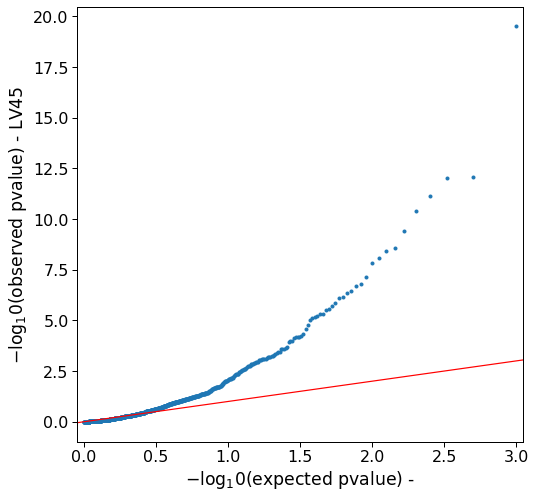

In [45]:
qqplot_unif(results)

### Top genes in LV

In [46]:
lv_genes = get_lv_genes(lv_code)
display(lv_genes.head(25))

,LV45,gene_band
HIST1H2BO,8.480948,6p22.1
HIST1H2BF,8.426226,6p22.2
HIST1H2BK,8.245903,6p22.1
HIST1H2BD,8.119013,6p22.2
HIST1H2BC,7.744137,6p22.2
HIST1H2AC,7.447932,6p22.2
HIST2H2BF,6.700409,1q21.2
HIST1H2AG,6.405812,6p22.1
HIST1H2BN,5.913649,6p22.1
HIST1H2AE,5.898213,6p22.2


In [47]:
# see bands of top genes
lv_genes.head(25)["gene_band"].value_counts().head(10)

6p22.2     11
6p22.1      6
1q42.13     2
1q21.2      1
11q23.3     1
1q42.12     1
17q25.1     1
4q23        1
19q13.2     1
17q24.1     0
Name: gene_band, dtype: int64

**Note**: Top genes in this LV are all from the same band, very likely causing high type I errors.

In [48]:
# take a look at all genes with non-zero weight
lv_genes_nonzero_weight = lv_genes[lv_genes[lv_code] > 0]

In [49]:
# how many genes have non-zero weight?
lv_genes_nonzero_weight.shape

(376, 2)

In [50]:
# how are bands distributed among zero weighted genes?
lv_genes_nonzero_weight["gene_band"].value_counts().head(10)

6p22.2     13
19p13.3     8
1q32.1      6
6p22.1      6
4q31.21     6
17q12       5
6p21.33     4
3p21.31     4
5q31.1      4
1q23.3      4
Name: gene_band, dtype: int64

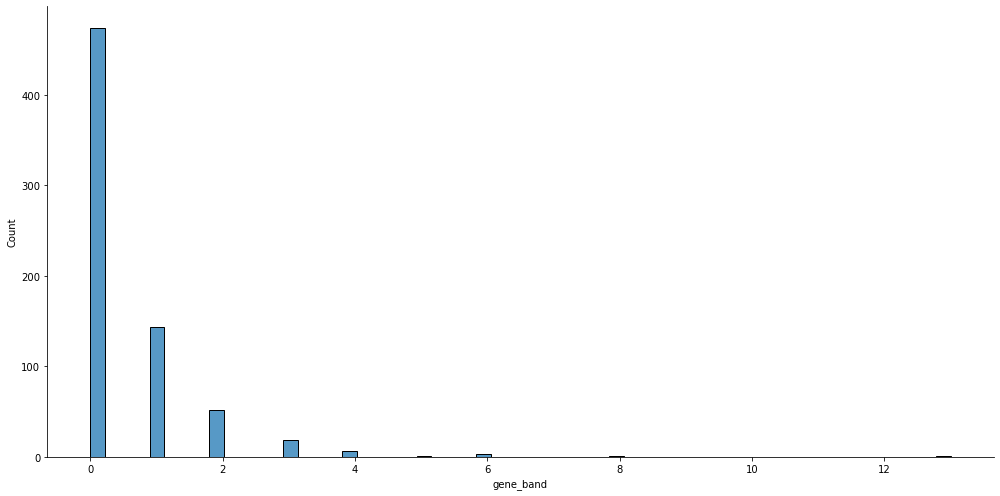

In [51]:
# distribution of amount of bands in LV
g = sns.displot(lv_genes_nonzero_weight["gene_band"].value_counts(), height=7, aspect=2)

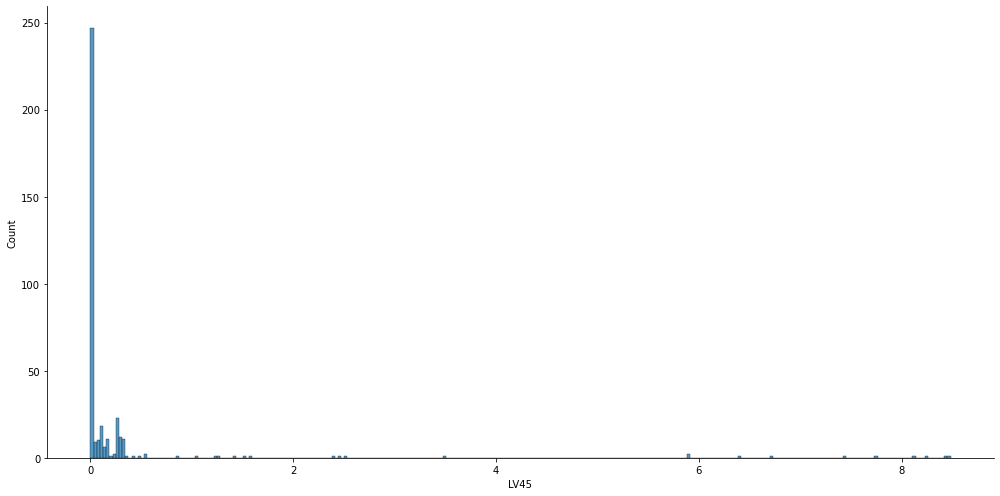

In [52]:
# distribution of weights in LV
g = sns.displot(lv_genes[lv_genes[lv_code] > 0][lv_code], height=7, aspect=2)

### Bottom genes in LV

In [53]:
lv_genes_zero_weight = lv_genes[lv_genes[lv_code] <= 0]

In [54]:
# how many genes have zero weight
lv_genes_zero_weight.shape

(6070, 2)

In [55]:
# how are bands distributed among zero weighted genes?
lv_genes_zero_weight["gene_band"].value_counts().head(20)

19p13.3     76
16p13.3     69
19p13.2     66
19q13.2     57
3p21.31     52
19q13.33    46
17p13.1     44
1q21.3      43
17q25.3     42
19q13.42    41
16q22.1     41
7q22.1      40
11q13.1     40
19p13.11    40
6p21.1      37
12q24.31    37
19q13.43    36
12p13.31    35
16p11.2     33
12q13.13    33
Name: gene_band, dtype: int64

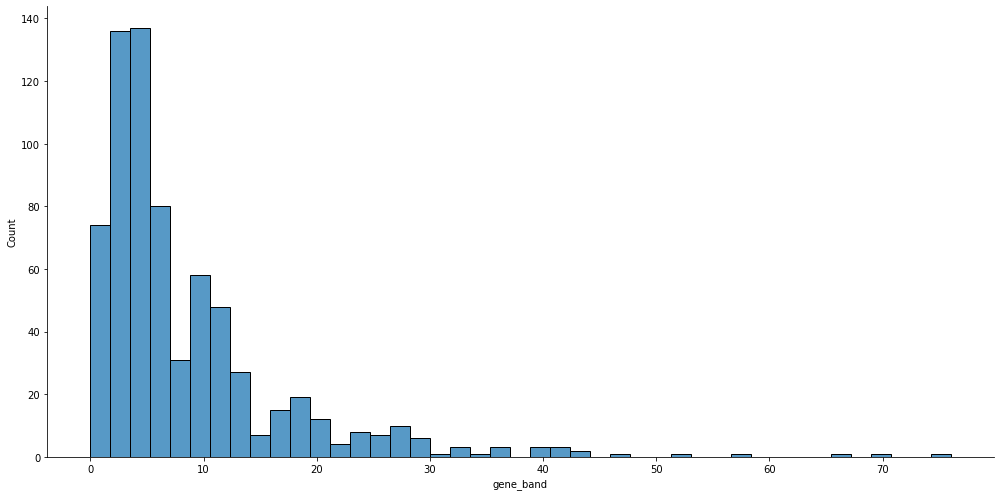

In [56]:
g = sns.displot(lv_genes_zero_weight["gene_band"].value_counts(), height=7, aspect=2)

## LV234

In [57]:
lv_code = "LV234"

In [58]:
results = dfs[dfs["lv"] == lv_code]

In [59]:
results.shape

(1000, 4)

In [60]:
results.head()

,lv,coef,pvalue,phenotype
233,LV234,0.004362,0.363127,random.pheno988
1220,LV234,-0.001422,0.545441,random.pheno589
2207,LV234,0.002184,0.430429,random.pheno385
3194,LV234,0.012870,0.150810,random.pheno5
4181,LV234,0.011771,0.172394,random.pheno74


In [61]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [62]:
show_prop(results, 0.01)

0.086

In [63]:
show_prop(results, 0.05)

0.154

In [64]:
show_prop(results, 0.10)

0.209

In [65]:
show_prop(results, 0.15)

0.241

In [66]:
show_prop(results, 0.20)

0.285

### QQplot

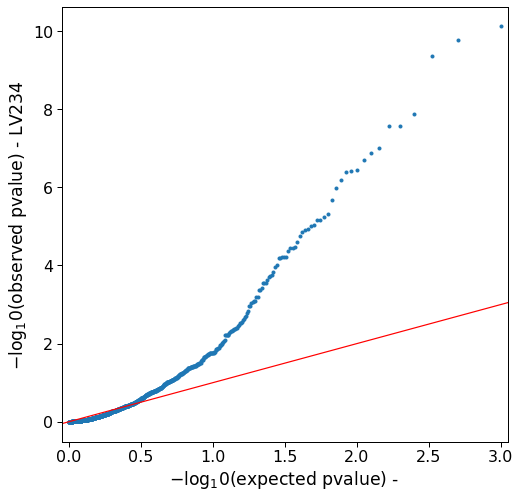

In [67]:
qqplot_unif(results)

### Top genes in LV

In [68]:
lv_genes = get_lv_genes(lv_code)
display(lv_genes.head(25))

,LV234,gene_band
HIST1H4E,7.379845,6p22.2
HIST1H3B,7.293635,6p22.2
HIST4H4,6.929394,12p12.3
HIST1H3H,6.863106,6p22.1
HIST1H3D,4.568047,6p22.2
HIST1H2BC,4.078396,6p22.2
HIST1H2AE,4.009782,6p22.2
HIST1H2BF,3.963254,6p22.2
HIST1H2BD,3.862981,6p22.2
HIST1H2BK,3.662444,6p22.1


In [69]:
# see bands of top genes
lv_genes.head(25)["gene_band"].value_counts().head(10)

6p22.2      12
6p22.1       5
12p12.3      1
17q21.31     1
17q25.1      1
1q42.12      1
1q42.13      1
11q23.3      1
4q23         1
16p11.2      1
Name: gene_band, dtype: int64

**Note**: same as LV45

In [70]:
# take a look at all genes with non-zero weight
lv_genes_nonzero_weight = lv_genes[lv_genes[lv_code] > 0]

In [71]:
# how many genes have non-zero weight?
lv_genes_nonzero_weight.shape

(1756, 2)

In [72]:
# how are bands distributed among zero weighted genes?
lv_genes_nonzero_weight["gene_band"].value_counts().head(10)

19q13.2     22
16p13.3     21
3p21.31     21
19p13.2     20
19p13.3     17
6p22.2      17
17p13.1     16
12q13.13    16
17q25.3     14
19q13.43    13
Name: gene_band, dtype: int64

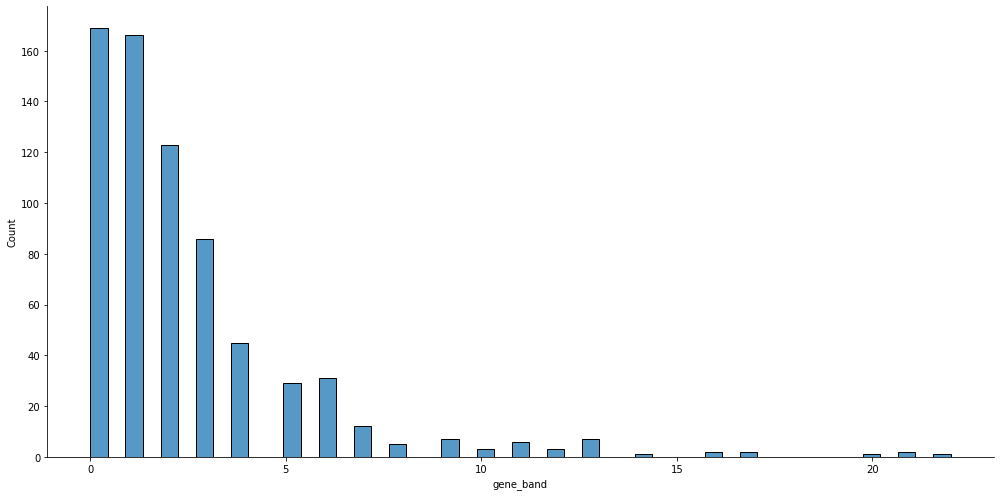

In [73]:
# distribution of amount of bands in LV
g = sns.displot(lv_genes_nonzero_weight["gene_band"].value_counts(), height=7, aspect=2)

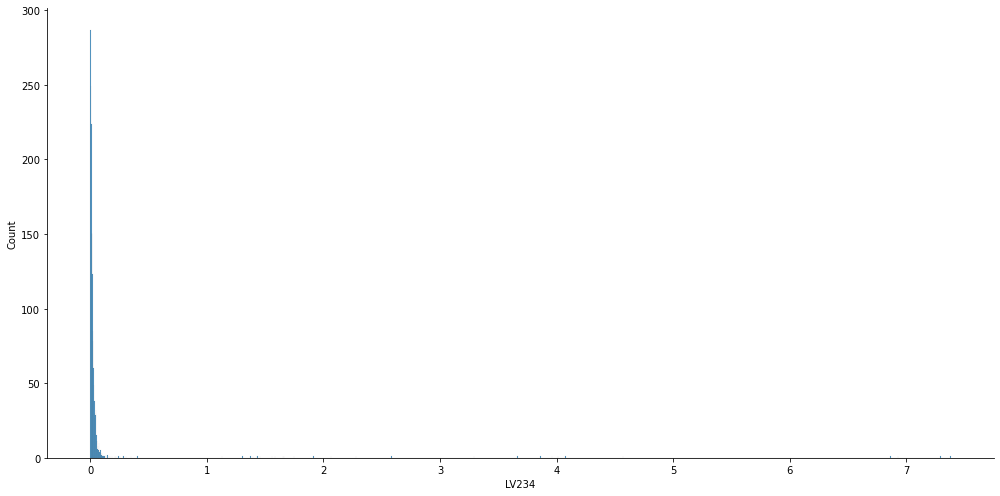

In [74]:
# distribution of weights in LV
g = sns.displot(lv_genes[lv_genes[lv_code] > 0][lv_code], height=7, aspect=2)

### Bottom genes in LV

In [75]:
lv_genes_zero_weight = lv_genes[lv_genes[lv_code] <= 0]

In [76]:
# how many genes have zero weight
lv_genes_zero_weight.shape

(4690, 2)

In [77]:
# how are bands distributed among zero weighted genes?
lv_genes_zero_weight["gene_band"].value_counts().head(20)

19p13.3     67
16p13.3     49
19p13.2     48
19q13.2     38
19q13.33    35
3p21.31     35
16q22.1     33
19q13.42    32
6p21.1      32
11q13.1     31
17q25.3     31
1q21.3      31
17p13.1     30
12q24.31    29
7q22.1      29
19p13.11    28
14q11.2     27
2q35        27
21q22.3     27
12p13.31    26
Name: gene_band, dtype: int64

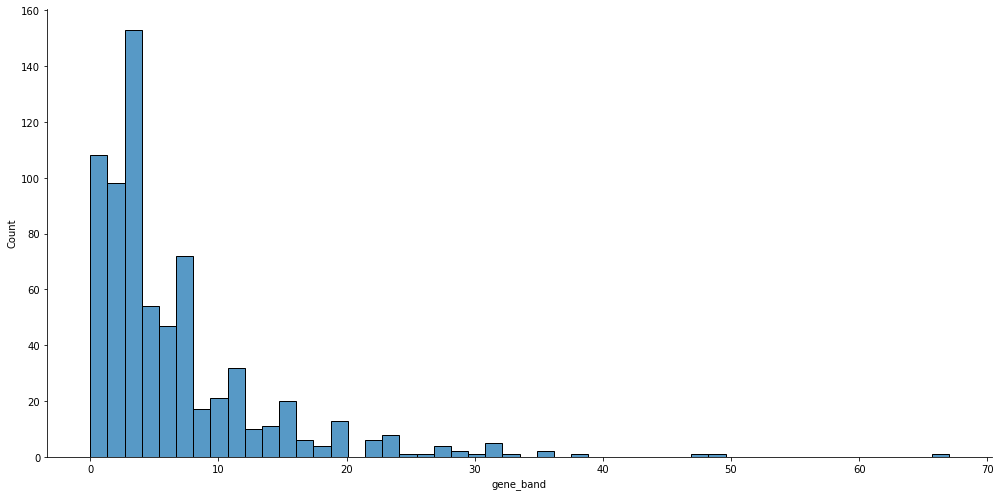

In [78]:
g = sns.displot(lv_genes_zero_weight["gene_band"].value_counts(), height=7, aspect=2)

## LV847

In [79]:
lv_code = "LV847"

In [80]:
results = dfs[dfs["lv"] == lv_code]

In [81]:
results.shape

(1000, 4)

In [82]:
results.head()

,lv,coef,pvalue,phenotype
846,LV847,-0.004228,0.632824,random.pheno988
1833,LV847,0.001357,0.456628,random.pheno589
2820,LV847,-0.003279,0.603777,random.pheno385
3807,LV847,0.008201,0.255203,random.pheno5
4794,LV847,0.014658,0.119692,random.pheno74


In [83]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [84]:
show_prop(results, 0.01)

0.091

In [85]:
show_prop(results, 0.05)

0.143

In [86]:
show_prop(results, 0.10)

0.191

In [87]:
show_prop(results, 0.15)

0.225

In [88]:
show_prop(results, 0.20)

0.264

### QQplot

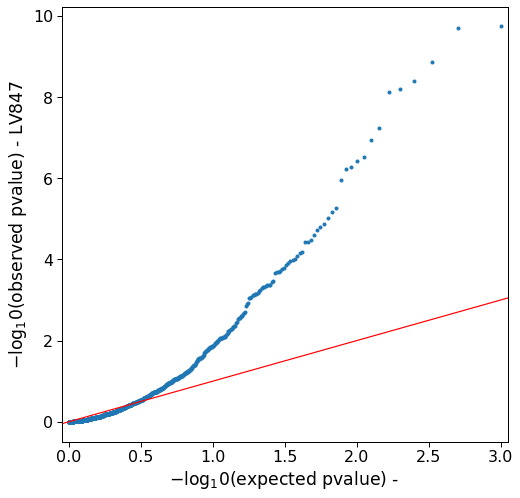

In [89]:
qqplot_unif(results)

### Top genes in LV

In [90]:
lv_genes = get_lv_genes(lv_code)
display(lv_genes.head(25))

,LV847,gene_band
HIST1H3D,6.805370,6p22.2
HIST1H3H,6.276783,6p22.1
HIST1H3B,6.099625,6p22.2
HIST1H4E,5.971181,6p22.2
HIST4H4,5.431832,12p12.3
HIST1H2BH,5.150647,6p22.2
HIST1H2AE,4.324334,6p22.2
HIST1H2BN,4.269944,6p22.1
HIST1H2BE,4.258760,6p22.2
HIST1H2AC,4.046811,6p22.2


In [91]:
# see bands of top genes
lv_genes.head(25)["gene_band"].value_counts().head(10)

6p22.2     15
6p22.1      5
1q42.13     2
11q23.3     1
17q25.1     1
12p12.3     1
17q23.2     0
18q12.2     0
18q12.1     0
18q11.2     0
Name: gene_band, dtype: int64

**Note**: same as LV45

In [92]:
# take a look at all genes with non-zero weight
lv_genes_nonzero_weight = lv_genes[lv_genes[lv_code] > 0]

In [93]:
# how many genes have non-zero weight?
lv_genes_nonzero_weight.shape

(1434, 2)

In [94]:
# how are bands distributed among zero weighted genes?
lv_genes_nonzero_weight["gene_band"].value_counts().head(10)

19p13.2     20
19p13.3     18
2q35        16
6p21.33     16
19q13.42    16
16p13.3     16
6p22.2      15
19q13.33    14
3p21.31     14
19q13.2     13
Name: gene_band, dtype: int64

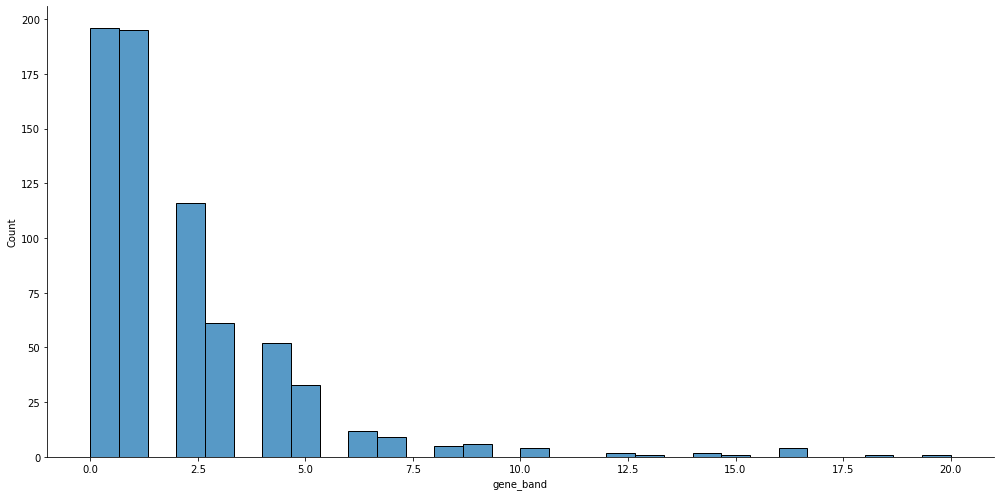

In [95]:
# distribution of amount of bands in LV
g = sns.displot(lv_genes_nonzero_weight["gene_band"].value_counts(), height=7, aspect=2)

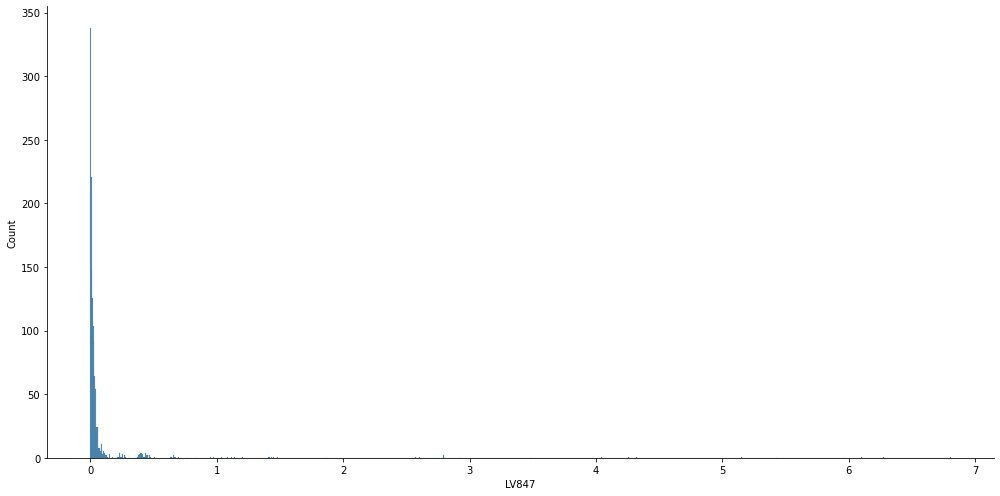

In [96]:
# distribution of weights in LV
g = sns.displot(lv_genes[lv_genes[lv_code] > 0][lv_code], height=7, aspect=2)

### Bottom genes in LV

In [97]:
lv_genes_zero_weight = lv_genes[lv_genes[lv_code] <= 0]

In [98]:
# how many genes have zero weight
lv_genes_zero_weight.shape

(5012, 2)

In [99]:
# how are bands distributed among zero weighted genes?
lv_genes_zero_weight["gene_band"].value_counts().head(20)

19p13.3     66
16p13.3     54
19p13.2     48
19q13.2     47
3p21.31     42
16q22.1     40
17q25.3     38
1q21.3      37
17p13.1     37
19p13.11    36
11q13.1     35
19q13.33    34
7q22.1      33
1q32.1      31
12q24.31    30
16p11.2     29
19q13.43    29
14q11.2     29
12p13.31    28
12q13.13    28
Name: gene_band, dtype: int64

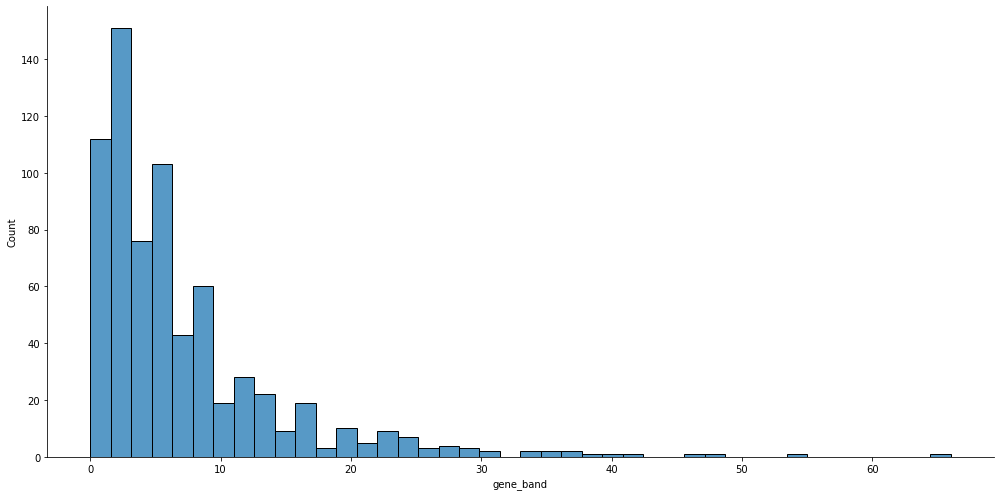

In [100]:
g = sns.displot(lv_genes_zero_weight["gene_band"].value_counts(), height=7, aspect=2)

## LV110

In [101]:
lv_code = "LV110"

In [102]:
results = dfs[dfs["lv"] == lv_code]

In [103]:
results.shape

(1000, 4)

In [104]:
results.head()

,lv,coef,pvalue,phenotype
109,LV110,-0.024160,0.973768,random.pheno988
1096,LV110,0.000731,0.476604,random.pheno589
2083,LV110,-0.005028,0.656726,random.pheno385
3070,LV110,-0.005938,0.683164,random.pheno5
4057,LV110,0.009946,0.212348,random.pheno74


In [105]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [106]:
show_prop(results, 0.01)

0.077

In [107]:
show_prop(results, 0.05)

0.127

In [108]:
show_prop(results, 0.10)

0.178

In [109]:
show_prop(results, 0.15)

0.213

In [110]:
show_prop(results, 0.20)

0.249

### QQplot

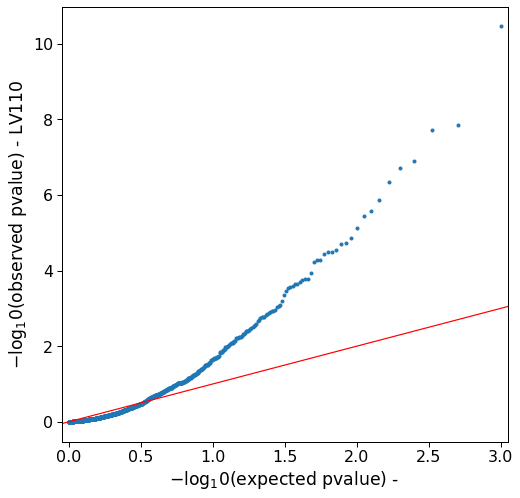

In [111]:
qqplot_unif(results)

### Top genes in LV

In [112]:
lv_genes = get_lv_genes(lv_code)
display(lv_genes.head(25))

,LV110,gene_band
HIST1H4D,6.862617,6p22.2
HIST1H2AD,6.425544,6p22.2
HIST1H1E,6.329128,6p22.2
HIST1H1C,5.829177,6p22.2
HIST1H1D,5.497928,6p22.2
HIST1H2BJ,5.265400,6p22.1
HIST1H4I,4.974646,6p22.1
HIST1H2BG,4.786019,6p22.2
HIST1H4H,4.607877,6p22.2
HIST1H2BE,3.079962,6p22.2


In [113]:
# see bands of top genes
lv_genes.head(25)["gene_band"].value_counts().head(10)

6p22.2      12
6p22.1       4
1q42.13      2
16p12.3      1
5q33.1       1
20q13.12     1
3p21.2       1
1p21.1       1
11q23.3      1
3q11.2       1
Name: gene_band, dtype: int64

Top genes in this LV are all from the same band, very likely causing high type I errors.

In [114]:
# take a look at all genes with non-zero weight
lv_genes_nonzero_weight = lv_genes[lv_genes[lv_code] > 0]

In [115]:
# how many genes have non-zero weight?
lv_genes_nonzero_weight.shape

(1854, 2)

In [116]:
# how are bands distributed among zero weighted genes?
lv_genes_nonzero_weight["gene_band"].value_counts().head(10)

19p13.3     30
19p13.2     28
16p13.3     27
11q13.1     23
19q13.33    22
19p13.11    18
19q13.42    18
3p21.31     17
19q13.2     16
16p11.2     15
Name: gene_band, dtype: int64

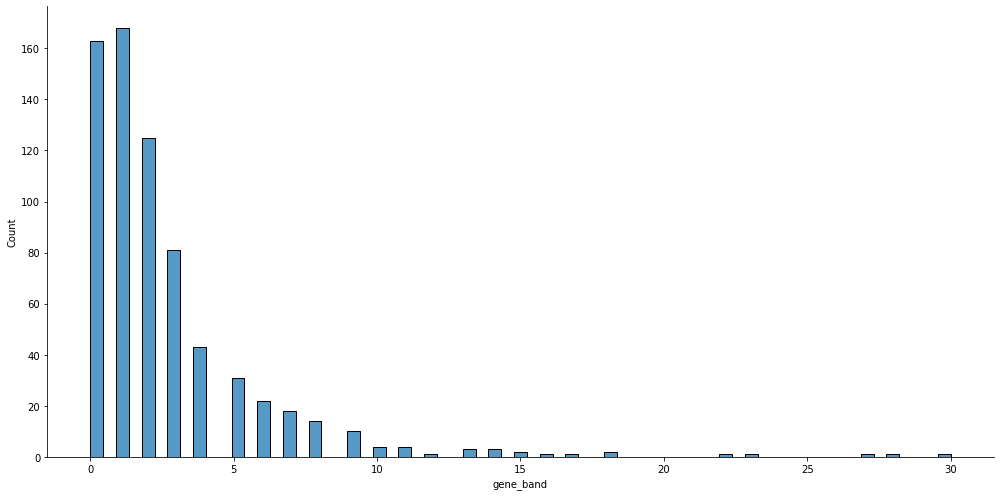

In [117]:
# distribution of amount of bands in LV
g = sns.displot(lv_genes_nonzero_weight["gene_band"].value_counts(), height=7, aspect=2)

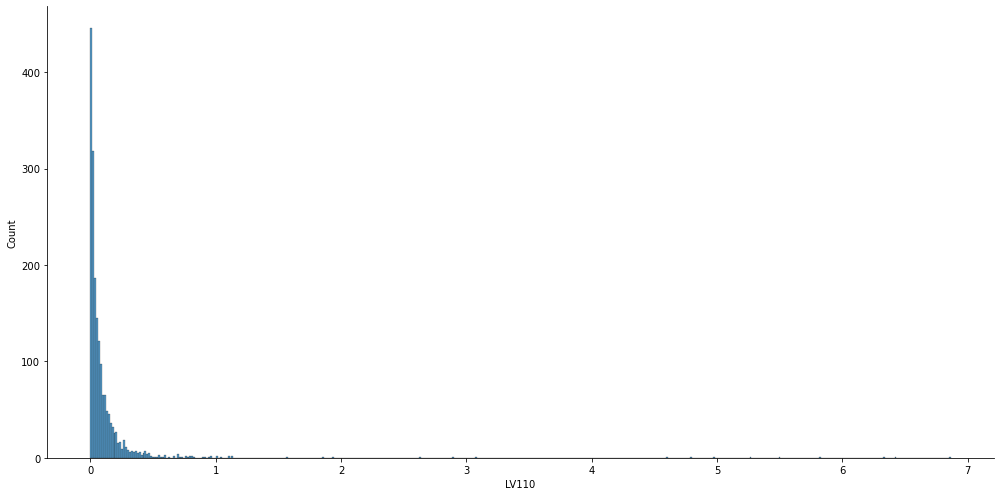

In [118]:
# distribution of weights in LV
g = sns.displot(lv_genes[lv_genes[lv_code] > 0][lv_code], height=7, aspect=2)

### Bottom genes in LV

In [119]:
lv_genes_zero_weight = lv_genes[lv_genes[lv_code] <= 0]

In [120]:
# how many genes have zero weight
lv_genes_zero_weight.shape

(4592, 2)

In [121]:
# how are bands distributed among zero weighted genes?
lv_genes_zero_weight["gene_band"].value_counts().head(20)

19p13.3     54
19q13.2     44
16p13.3     43
19p13.2     40
1q21.3      39
3p21.31     39
16q22.1     33
17p13.1     33
17q25.3     32
12q24.31    31
7q22.1      31
14q11.2     31
1q32.1      30
17q12       28
17q11.2     28
12q13.13    27
6p21.1      26
19q13.33    26
19q13.42    25
11q23.3     24
Name: gene_band, dtype: int64

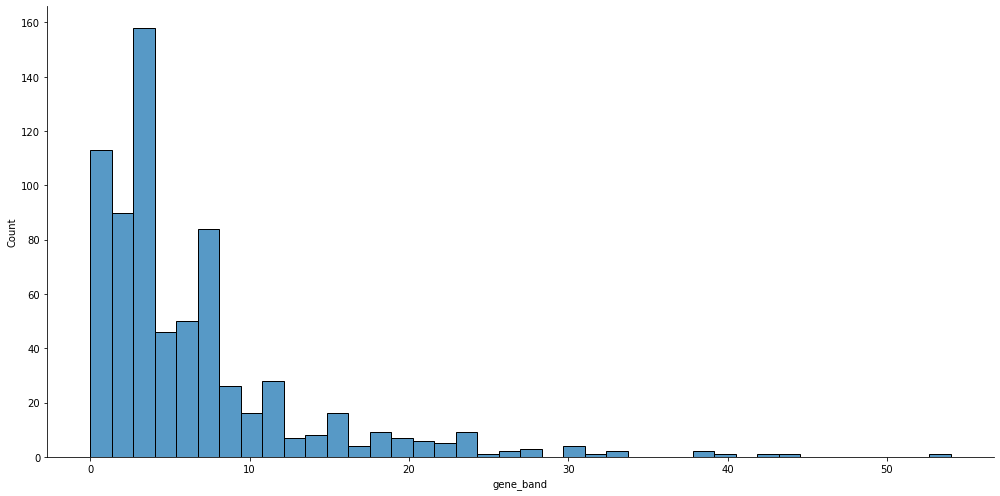

In [122]:
g = sns.displot(lv_genes_zero_weight["gene_band"].value_counts(), height=7, aspect=2)

## LV769

In [123]:
lv_code = "LV769"

In [124]:
results = dfs[dfs["lv"] == lv_code]

In [125]:
results.shape

(1000, 4)

In [126]:
results.head()

,lv,coef,pvalue,phenotype
768,LV769,0.012389,0.160028,random.pheno988
1755,LV769,0.001512,0.451694,random.pheno589
2742,LV769,0.002059,0.434367,random.pheno385
3729,LV769,-0.021138,0.955120,random.pheno5
4716,LV769,-0.018998,0.936360,random.pheno74


In [127]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [128]:
show_prop(results, 0.01)

0.038

In [129]:
show_prop(results, 0.05)

0.12

In [130]:
show_prop(results, 0.10)

0.198

In [131]:
show_prop(results, 0.15)

0.25

In [132]:
show_prop(results, 0.20)

0.307

### QQplot

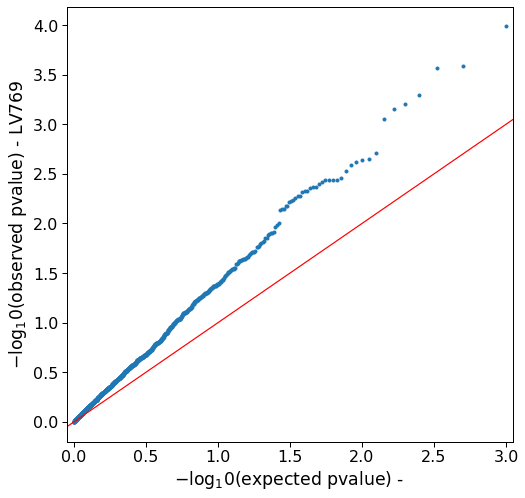

In [133]:
qqplot_unif(results)

The QQplot here is not the same as the LVs before. In previous LVs, there are very small pvalues, likely because of the genes from the same region at the top of the LV.

Here p-values are consistently smaller than expected, but there are no very small p-values.

### Top genes in LV

In [134]:
lv_genes = get_lv_genes(lv_code)
display(lv_genes.head(25))

,LV769,gene_band
RCHY1,4.709602,4q21.1
MICB,4.094715,6p21.33
FAM20B,2.025532,1q25.2
GLUD1,1.944526,10q23.2
SPHK2,1.873681,19q13.33
UBE2T,1.610870,1q32.1
SPDYA,1.517940,2p23.2
CYP26B1,1.394458,2p13.2
MREG,1.239710,2q35
ZNF584,1.126256,19q13.43


Ok, first LV that does not have genes from the same band at the top. What's going on here?

In [135]:
# see bands of top genes
lv_genes.head(25)["gene_band"].value_counts().head(10)

6p21.33    2
7q36.1     2
4q13.3     1
8q21.13    1
9p13.2     1
2p23.2     1
5q31.1     1
4q21.1     1
2q11.2     1
1q25.2     1
Name: gene_band, dtype: int64

There are same genes from the same band at the top, but not that many as the other LVs.
**However**, top genes from chr 6 are here. Those might be highly correlated.

In [136]:
# take a look at all genes with non-zero weight
lv_genes_nonzero_weight = lv_genes[lv_genes[lv_code] > 0]

In [137]:
# how many genes have non-zero weight?
lv_genes_nonzero_weight.shape

(2457, 2)

In [138]:
# how are bands distributed among zero weighted genes?
lv_genes_nonzero_weight["gene_band"].value_counts().head(10)

19q13.2     32
19p13.3     28
16p13.3     25
19p13.2     25
1q21.3      24
19q13.33    23
11q13.1     20
3p21.31     20
11q13.2     19
19q13.42    19
Name: gene_band, dtype: int64

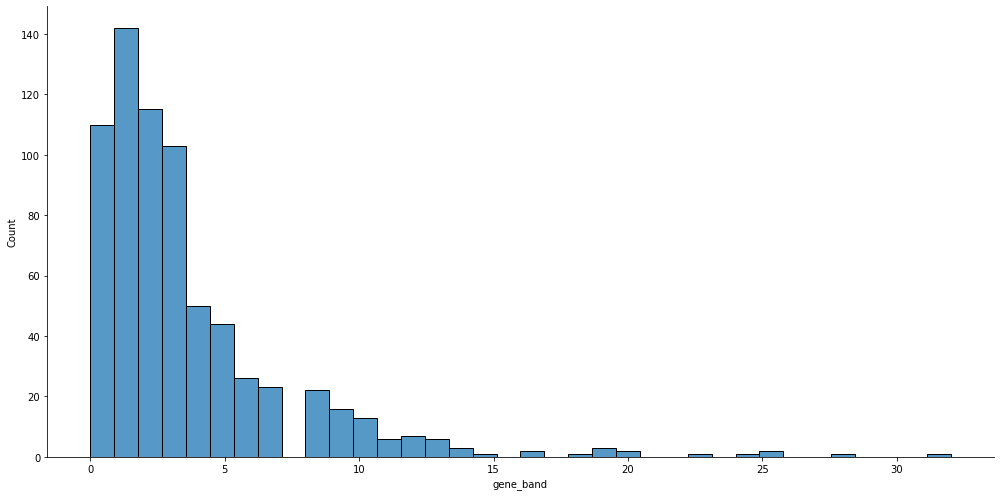

In [139]:
# distribution of amount of bands in LV
g = sns.displot(lv_genes_nonzero_weight["gene_band"].value_counts(), height=7, aspect=2)

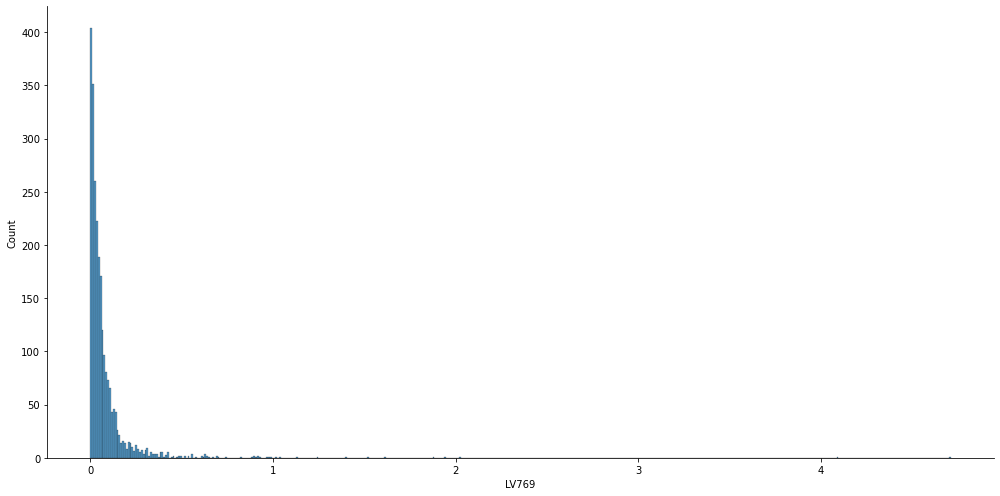

In [140]:
# distribution of weights in LV
g = sns.displot(lv_genes[lv_genes[lv_code] > 0][lv_code], height=7, aspect=2)

### Bottom genes in LV

In [141]:
lv_genes_zero_weight = lv_genes[lv_genes[lv_code] <= 0]

In [142]:
# how many genes have zero weight
lv_genes_zero_weight.shape

(3989, 2)

In [143]:
# how are bands distributed among zero weighted genes?
lv_genes_zero_weight["gene_band"].value_counts().head(20)

19p13.3     56
16p13.3     45
19p13.2     43
3p21.31     36
7q22.1      33
17q25.3     32
16q22.1     28
19q13.2     28
17p13.1     27
6p21.1      27
19p13.11    25
14q11.2     25
12q24.31    25
19q13.33    25
12p13.31    25
11q13.1     24
19q13.42    24
17q12       24
19q13.43    23
17q11.2     23
Name: gene_band, dtype: int64

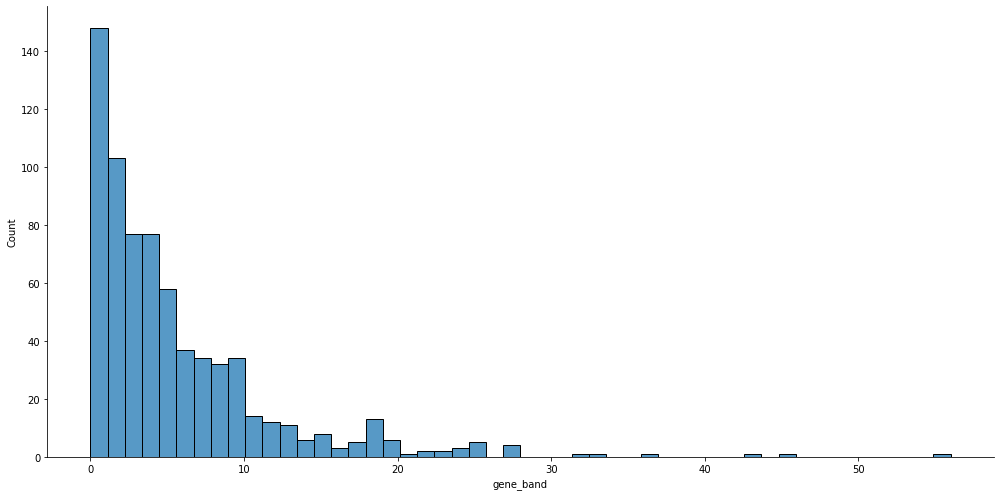

In [144]:
g = sns.displot(lv_genes_zero_weight["gene_band"].value_counts(), height=7, aspect=2)

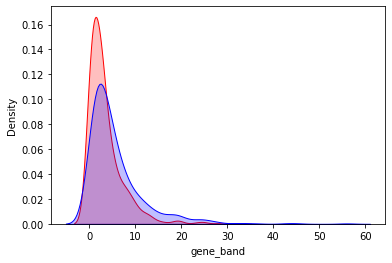

In [145]:
# compare band sizes distribution from top and bottom genes
fig = sns.kdeplot(
    lv_genes_nonzero_weight["gene_band"].value_counts(), shade=True, color="r"
)
fig = sns.kdeplot(
    lv_genes_zero_weight["gene_band"].value_counts(), shade=True, color="b"
)
plt.show()

## LV800

In [146]:
lv_code = "LV800"

In [147]:
results = dfs[dfs["lv"] == lv_code]

In [148]:
results.shape

(1000, 4)

In [149]:
results.head()

,lv,coef,pvalue,phenotype
799,LV800,0.011483,0.178353,random.pheno988
1786,LV800,0.003140,0.400517,random.pheno589
2773,LV800,-0.010199,0.793478,random.pheno385
3760,LV800,-0.021727,0.959422,random.pheno5
4747,LV800,-0.009028,0.765641,random.pheno74


In [150]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [151]:
show_prop(results, 0.01)

0.048

In [152]:
show_prop(results, 0.05)

0.116

In [153]:
show_prop(results, 0.10)

0.181

In [154]:
show_prop(results, 0.15)

0.216

In [155]:
show_prop(results, 0.20)

0.268

### QQplot

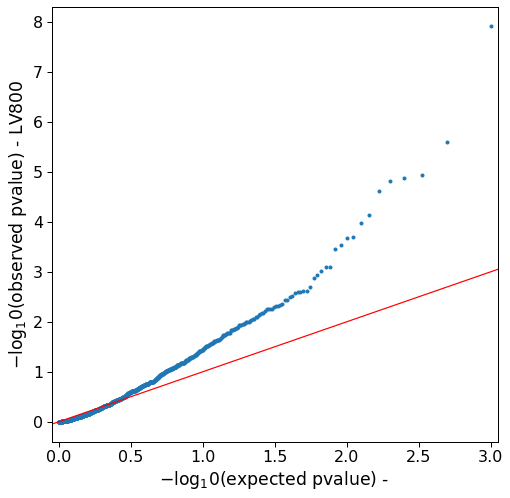

In [156]:
qqplot_unif(results)

**Note**: looks similar to LV769. This one has smaller minimum p-values.

### Top genes in LV

In [157]:
lv_genes = get_lv_genes(lv_code)
display(lv_genes.head(25))

,LV800,gene_band
ZNF20,1.980700,19p13.2
ZNF606,1.931659,19q13.43
ZNF551,1.832833,19q13.43
ZNF543,1.701683,19q13.43
ZNF14,1.640789,19p13.11
ZNF625,1.612766,19p13.2
ZNF234,1.608893,19q13.31
ZNF468,1.601126,19q13.41
ZFP28,1.591189,19q13.43
ZNF485,1.586159,10q11.21


**Note**: similar to the first LVs in that top genes are mostly from the same band, but here weights are way smaller.

In [158]:
# see bands of top genes
lv_genes.head(25)["gene_band"].value_counts().head(10)

19q13.43    6
19p13.2     4
19q13.31    3
19q13.41    3
10q11.21    1
7q11.21     1
19q13.12    1
19p13.11    1
19p12       1
12q24.33    1
Name: gene_band, dtype: int64

There are same genes from the same band at the top, but not that many as the other LVs.
**However**, top genes from chr 6 are here. Those might be highly correlated.

In [159]:
# take a look at all genes with non-zero weight
lv_genes_nonzero_weight = lv_genes[lv_genes[lv_code] > 0]

In [160]:
# how many genes have non-zero weight?
lv_genes_nonzero_weight.shape

(2038, 2)

In [161]:
# how are bands distributed among zero weighted genes?
lv_genes_nonzero_weight["gene_band"].value_counts().head(10)

19p13.2     37
19q13.43    32
19q13.2     27
19p13.3     27
16p13.3     22
19q13.41    22
19q13.12    21
19p13.11    18
11q13.1     17
11q13.2     17
Name: gene_band, dtype: int64

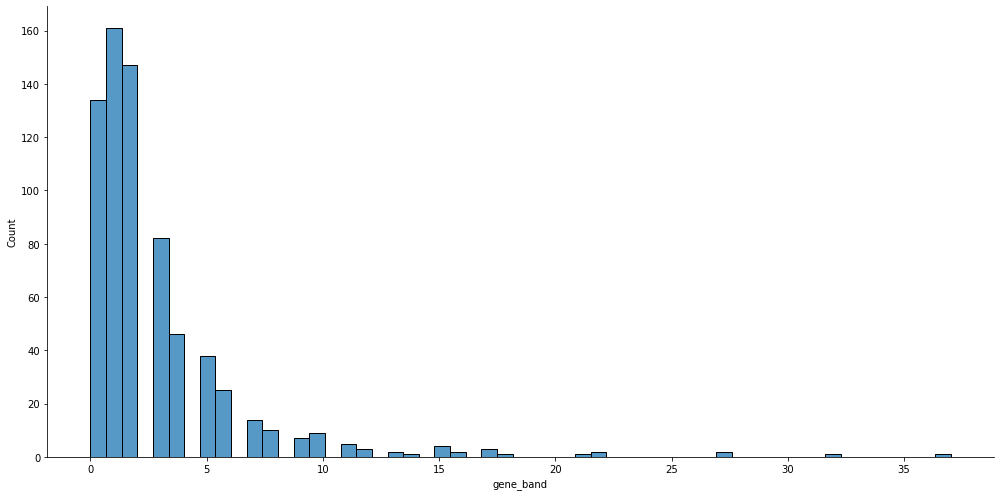

In [162]:
# distribution of amount of bands in LV
g = sns.displot(lv_genes_nonzero_weight["gene_band"].value_counts(), height=7, aspect=2)

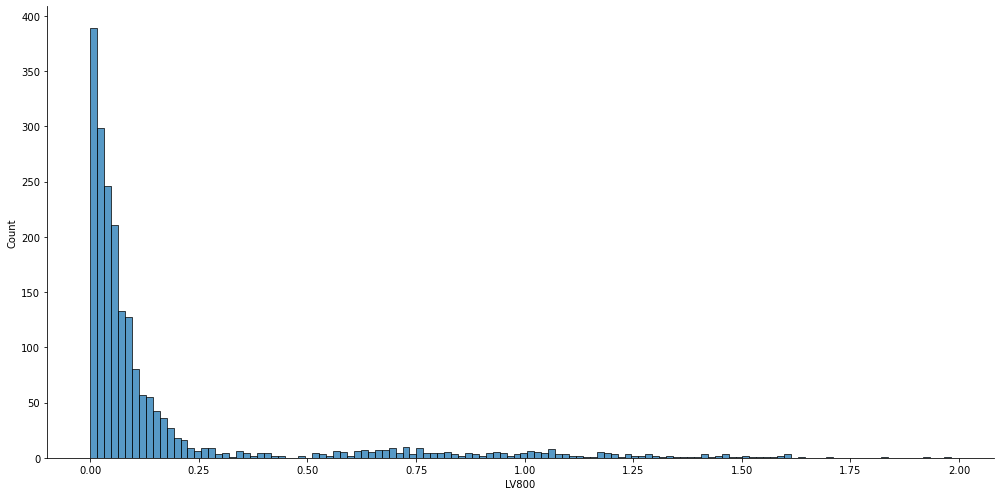

In [163]:
# distribution of weights in LV
g = sns.displot(lv_genes[lv_genes[lv_code] > 0][lv_code], height=7, aspect=2)

**TODO**

### Bottom genes in LV

In [164]:
lv_genes_zero_weight = lv_genes[lv_genes[lv_code] <= 0]

In [165]:
# how many genes have zero weight
lv_genes_zero_weight.shape

(4408, 2)

In [166]:
# how are bands distributed among zero weighted genes?
lv_genes_zero_weight["gene_band"].value_counts().head(20)

19p13.3     57
16p13.3     48
3p21.31     40
17q25.3     39
1q21.3      36
19q13.2     33
17p13.1     31
19p13.2     31
19q13.33    31
16q22.1     29
12q24.31    29
12p13.31    28
7q22.1      28
16p11.2     28
11q13.1     27
19q13.42    27
17q25.1     27
14q11.2     26
1q32.1      25
11p15.4     25
Name: gene_band, dtype: int64

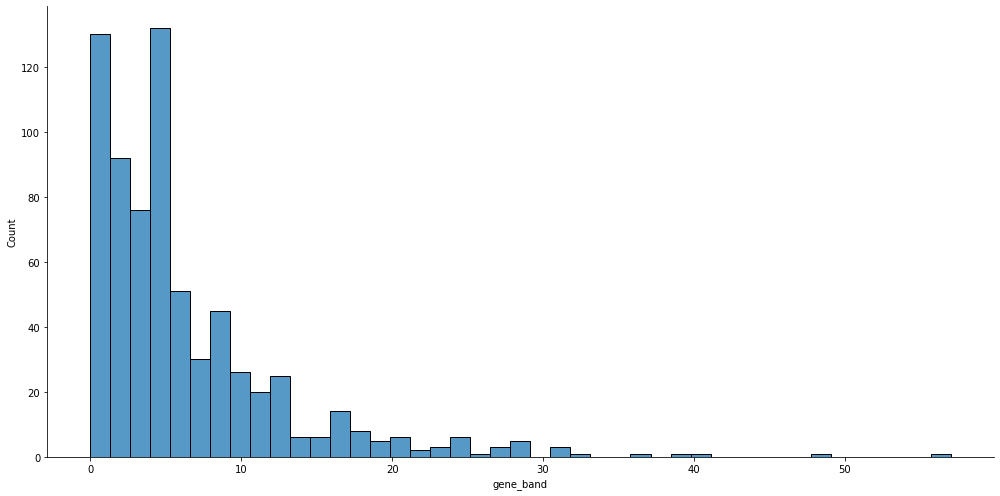

In [167]:
g = sns.displot(lv_genes_zero_weight["gene_band"].value_counts(), height=7, aspect=2)

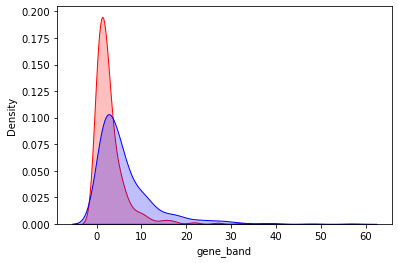

In [168]:
# compare band sizes distribution from top and bottom genes
fig = sns.kdeplot(
    lv_genes_nonzero_weight["gene_band"].value_counts(), shade=True, color="r"
)
fig = sns.kdeplot(
    lv_genes_zero_weight["gene_band"].value_counts(), shade=True, color="b"
)
plt.show()

## Notes

There are LVs with high mean type I errors that have different properties:

1. LVs like LV45-LV110 (the first ones) have:
    1. Smaller minimum p-values (qqplots deviate late and quickly), with -log(p) around 10 or 20.
    1. High gene weights (around 6 to 9)...
    1. Genes from the same band at the top.
    1. Relatively fewer genes with non-zero (> 0) weights, from ~400 to ~1600.
    1. Cytobands usually have 1 or 2 genes with non-zero weight, but there are some with many genes.
        * LV45 has a single band with 13 genes, and all the rest have 8 or less...
        * ... whereas the rest of these LVs have many bands with many genes (this could explain why LV45 is the worst).

1. LVs like LV769 have:
    1. Larger p-values (qqplots deviate early) with -log10(p) around 4
    1. Lower gene weights (around 2 to 4).
    1. Genes at the top are not from the same band.
    1. Larger number of genes with non-zero (> 0) weights, more than 2400.
    1. Same pattern regarding cybands.

1. LVs like LV800 are mixed between the other two:
    1. QQ plots show early deviation but also smaller minimum pvalues.
    1. Lower gene weights (less than 2)
    1. Gene weights are a bit more uniform in LV800, with more genes having similar weights around 0.75 or 1.00.
    1. Genes at the top are from the same band.
    1. Same pattern regarding cybands.

Besides the ratio of genes with non-zero weights and zero, I didn't find any distinction **among genes with zero weight**.

# LVs with expected mean type I error

In [169]:
display(lvs_expected_error.sort_values("5").head(20))

,lv,1,5,10
519,LV567,0.016,0.049,0.097
523,LV570,0.016,0.049,0.084
693,LV723,0.013,0.049,0.107
348,LV412,0.009,0.049,0.100
664,LV698,0.008,0.049,0.092
379,LV440,0.008,0.049,0.092
388,LV449,0.014,0.049,0.093
640,LV676,0.012,0.049,0.094
624,LV661,0.010,0.049,0.112
609,LV648,0.007,0.049,0.087


Here I'm manually selecting from this list, since I want those that are well calibrated across different p-value thresholds.

In [170]:
lv_results_expected = {}

## LV412

In [171]:
lv_code = "LV412"

In [172]:
results = dfs[dfs["lv"] == lv_code]

In [173]:
results.shape

(1000, 4)

In [174]:
results.head()

,lv,coef,pvalue,phenotype
411,LV412,-0.010372,0.797435,random.pheno988
1398,LV412,-0.015866,0.898571,random.pheno589
2385,LV412,0.019627,0.057581,random.pheno385
3372,LV412,0.009720,0.217653,random.pheno5
4359,LV412,0.010105,0.208680,random.pheno74


In [175]:
# save for future reference
lv_results_expected[lv_code] = results

### Mean type I errors at different thresholds

In [176]:
show_prop(results, 0.01)

0.009

In [177]:
show_prop(results, 0.05)

0.049

In [178]:
show_prop(results, 0.10)

0.1

In [179]:
show_prop(results, 0.15)

0.141

In [180]:
show_prop(results, 0.20)

0.187

### QQplot

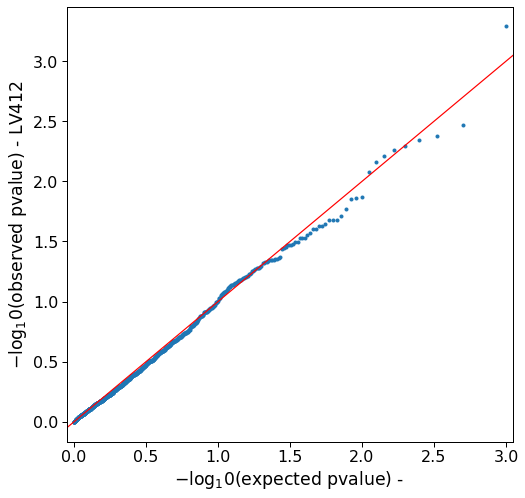

In [181]:
qqplot_unif(results)

**Note**

### Top genes in LV

In [182]:
lv_genes = get_lv_genes(lv_code)
display(lv_genes.head(25))

,LV412,gene_band
KCNH8,5.521022,3p24.3
ZNF135,3.878779,19q13.43
ZNF614,3.775552,19q13.41
ZNF606,2.929764,19q13.43
PANK1,2.749045,10q23.31
ABCB9,2.445773,12q24.31
ZNF443,2.197429,19p13.2
ZNF649,1.970191,19q13.41
SKIV2L,1.735204,6p21.33
CLCN3,1.721717,4q33


**Note**: hm, there are some genes from the same bands at the top here.

In [183]:
# see bands of top genes
lv_genes.head(25)["gene_band"].value_counts().head(10)

19q13.41    2
19q13.43    2
1p36.12     1
1q41        1
8q24.3      1
17p11.2     1
17q12       1
6p21.33     1
2q31.1      1
6p24.1      1
Name: gene_band, dtype: int64

There are same genes from the same band at the top, but not that many as the other LVs.

This pattern is more similar to LV769, but this one has expected mean type I errors. Why?

In [184]:
# take a look at all genes with non-zero weight
lv_genes_nonzero_weight = lv_genes[lv_genes[lv_code] > 0]

In [185]:
# how many genes have non-zero weight?
lv_genes_nonzero_weight.shape

(2805, 2)

Similar to LV769.

In [186]:
# how are bands distributed among zero weighted genes?
lv_genes_nonzero_weight["gene_band"].value_counts().head(10)

19p13.3     44
19p13.2     33
3p21.31     28
16p13.3     25
19q13.2     23
12p13.31    21
17p13.1     20
16q22.1     20
6p21.1      20
12q24.31    19
Name: gene_band, dtype: int64

Similar to LV769.

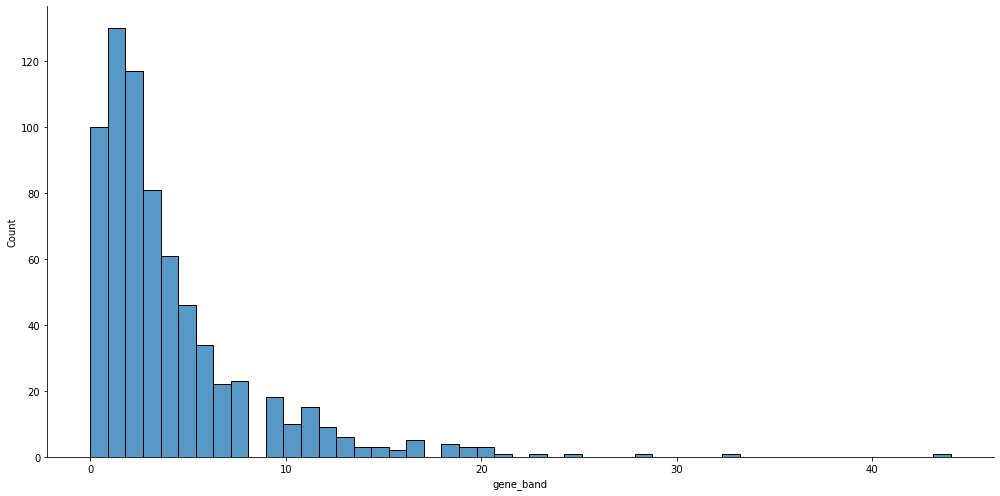

In [187]:
# distribution of amount of bands in LV
g = sns.displot(lv_genes_nonzero_weight["gene_band"].value_counts(), height=7, aspect=2)

Similar to LV769.

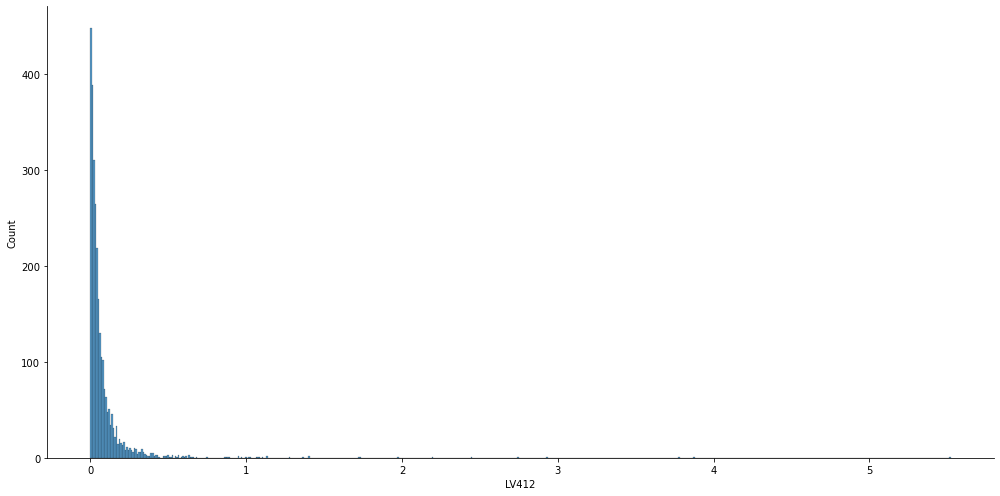

In [188]:
# distribution of weights in LV
g = sns.displot(lv_genes[lv_genes[lv_code] > 0][lv_code], height=7, aspect=2)

Similar to LV769.

### Bottom genes in LV

In [189]:
lv_genes_zero_weight = lv_genes[lv_genes[lv_code] <= 0]

In [190]:
# how many genes have zero weight
lv_genes_zero_weight.shape

(3641, 2)

Similar to LV769.

In [191]:
# how are bands distributed among zero weighted genes?
lv_genes_zero_weight["gene_band"].value_counts().head(20)

16p13.3     45
19p13.3     40
19q13.2     37
19p13.2     35
17q25.3     34
19q13.42    30
19q13.33    30
7q22.1      29
11q13.1     28
3p21.31     28
16p11.2     27
17p13.1     26
16q22.1     24
1q21.3      24
19p13.11    23
19q13.43    22
11p15.4     22
8q24.3      21
12q13.13    21
6p21.33     19
Name: gene_band, dtype: int64

Similar to LV769.

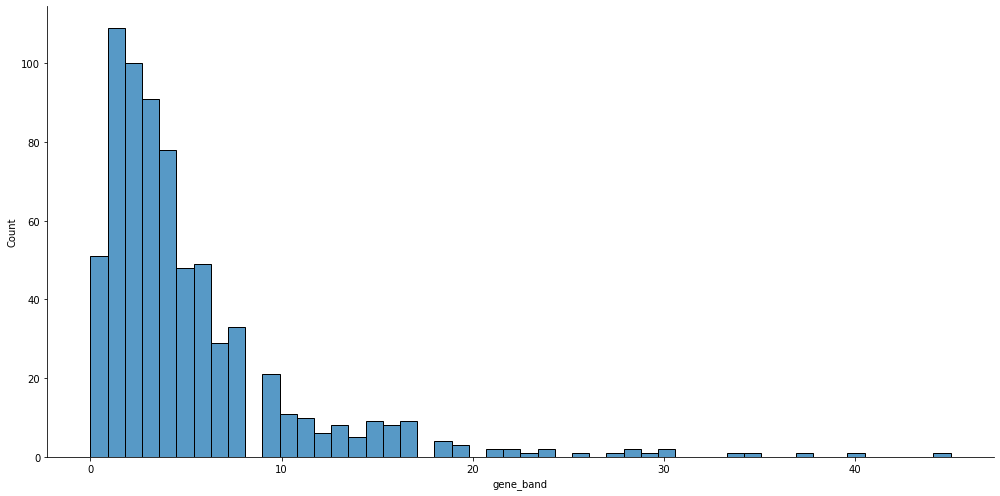

In [192]:
g = sns.displot(lv_genes_zero_weight["gene_band"].value_counts(), height=7, aspect=2)

Hm, this is not exactly the same as LV769. Here the distribution of band sizes among genes with zero weight is similar to that with genes with non-zero weights.

So maybe that imbalance is what makes an LV to have high mean type I errors.

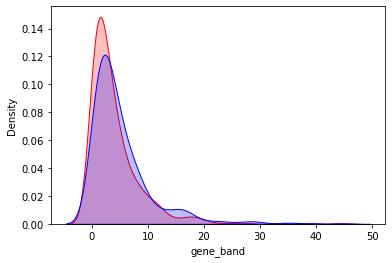

In [193]:
# compare band sizes distribution from top and bottom genes
fig = sns.kdeplot(
    lv_genes_nonzero_weight["gene_band"].value_counts(), shade=True, color="r"
)
fig = sns.kdeplot(
    lv_genes_zero_weight["gene_band"].value_counts(), shade=True, color="b"
)
plt.show()

Yep, the distributions are more similar in this LV than those in LV769 or LV800.

## LV57

In [194]:
lv_code = "LV57"

In [195]:
results = dfs[dfs["lv"] == lv_code]

In [196]:
results.shape

(1000, 4)

In [197]:
results.head()

,lv,coef,pvalue,phenotype
56,LV57,-0.019936,0.945226,random.pheno988
1043,LV57,0.023756,0.028268,random.pheno589
2030,LV57,0.015346,0.109023,random.pheno385
3017,LV57,-0.003606,0.613875,random.pheno5
4004,LV57,0.014074,0.129313,random.pheno74


In [198]:
# save for future reference
lv_results_expected[lv_code] = results

### Mean type I errors at different thresholds

In [199]:
show_prop(results, 0.01)

0.012

In [200]:
show_prop(results, 0.05)

0.049

In [201]:
show_prop(results, 0.10)

0.093

In [202]:
show_prop(results, 0.15)

0.137

In [203]:
show_prop(results, 0.20)

0.186

### QQplot

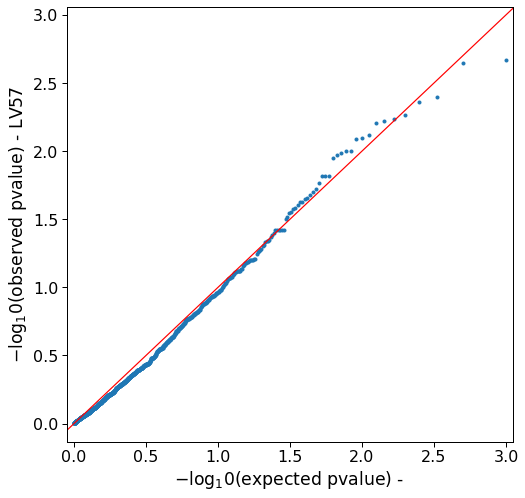

In [204]:
qqplot_unif(results)

**Note**

### Top genes in LV

In [205]:
lv_genes = get_lv_genes(lv_code)
display(lv_genes.head(25))

,LV57,gene_band
CTLA4,7.918721,2q33.2
IL10,6.930030,1q32.1
IL9,6.734138,5q31.1
TNFSF8,5.758800,9q33.1
ZBED2,5.054312,3q13.13
TNF,4.788832,6p21.33
IL2RA,4.617858,10p15.1
IL4,4.128203,5q31.1
IL12RB2,3.817266,1p31.3
ICOS,3.656751,2q33.2


In [206]:
# see bands of top genes
lv_genes.head(25)["gene_band"].value_counts().head(10)

2q33.2      3
6p21.33     2
17q12       2
5q31.1      2
7q31.1      1
14q12       1
1q23.2      1
17q21.32    1
1q24.3      1
1p36.23     1
Name: gene_band, dtype: int64

In [207]:
# take a look at all genes with non-zero weight
lv_genes_nonzero_weight = lv_genes[lv_genes[lv_code] > 0]

In [208]:
# how many genes have non-zero weight?
lv_genes_nonzero_weight.shape

(2037, 2)

Similar to LV769 and LV412

In [209]:
# how are bands distributed among zero weighted genes?
lv_genes_nonzero_weight["gene_band"].value_counts().head(10)

12p13.31    19
16p13.3     19
17q12       18
1q32.1      17
11q23.3     17
19p13.3     17
19q13.2     17
17p13.1     15
19p13.2     15
16q22.1     15
Name: gene_band, dtype: int64

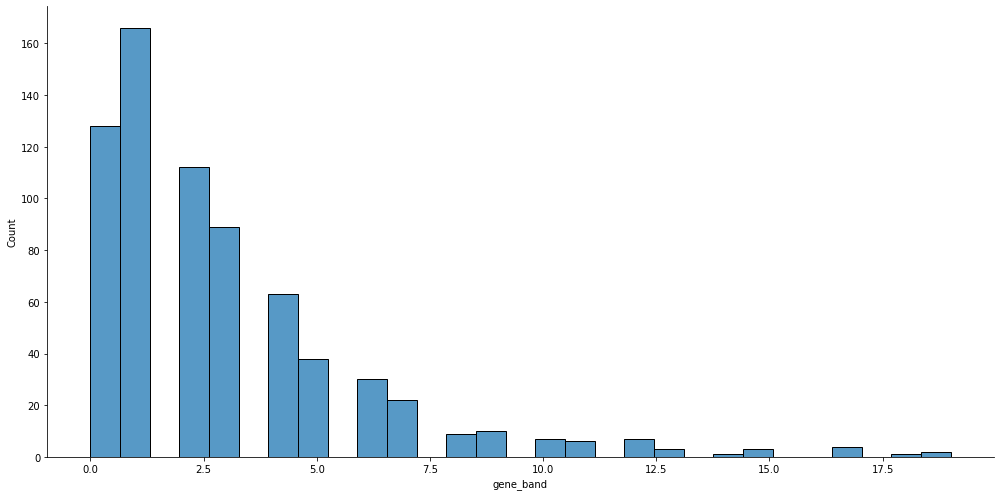

In [210]:
# distribution of amount of bands in LV
g = sns.displot(lv_genes_nonzero_weight["gene_band"].value_counts(), height=7, aspect=2)

The distribution seems similar to LV412, but here we have smaller bands.

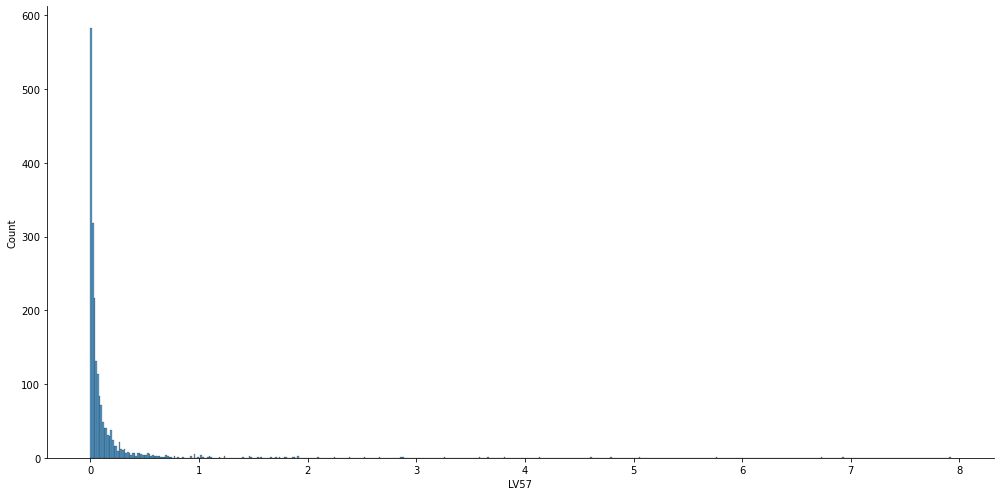

In [211]:
# distribution of weights in LV
g = sns.displot(lv_genes[lv_genes[lv_code] > 0][lv_code], height=7, aspect=2)

Similar to LV412.

### Bottom genes in LV

In [212]:
lv_genes_zero_weight = lv_genes[lv_genes[lv_code] <= 0]

In [213]:
# how many genes have zero weight
lv_genes_zero_weight.shape

(4409, 2)

Compared with LV412, we have more zero weight genes here.

In [214]:
# how are bands distributed among zero weighted genes?
lv_genes_zero_weight["gene_band"].value_counts().head(20)

19p13.3     67
19p13.2     53
16p13.3     51
3p21.31     44
19q13.2     43
7q22.1      35
11q13.1     35
17q25.3     34
19q13.33    34
19p13.11    31
1q21.3      31
17p13.1     31
19q13.42    30
16q22.1     29
12q13.13    28
16p11.2     27
19q13.43    27
12q24.31    26
8q24.3      25
6p21.1      25
Name: gene_band, dtype: int64

Similar to LV769.

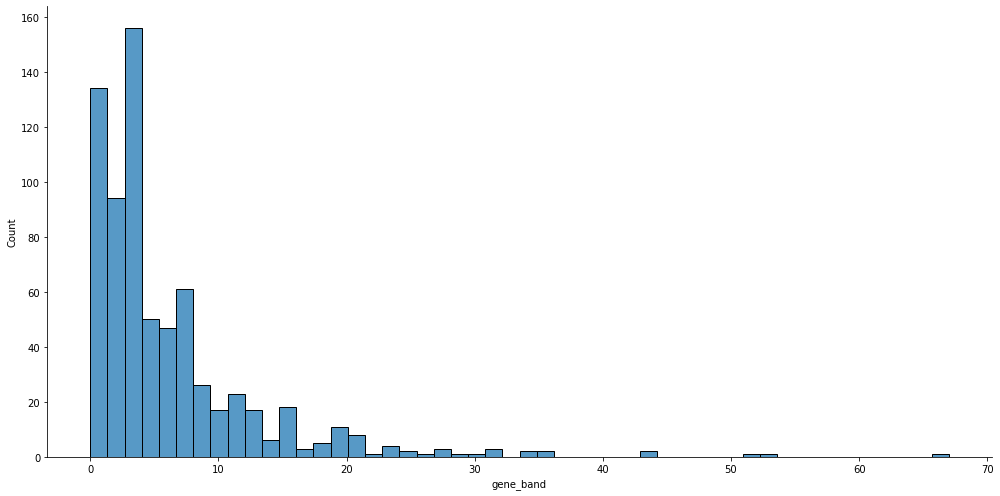

In [215]:
g = sns.displot(lv_genes_zero_weight["gene_band"].value_counts(), height=7, aspect=2)

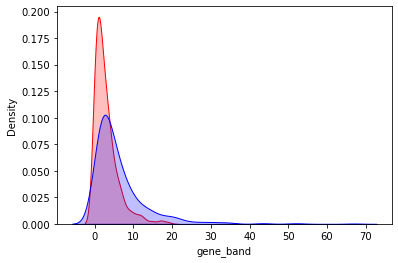

In [216]:
# compare band sizes distribution from top and bottom genes
fig = sns.kdeplot(
    lv_genes_nonzero_weight["gene_band"].value_counts(), shade=True, color="r"
)
fig = sns.kdeplot(
    lv_genes_zero_weight["gene_band"].value_counts(), shade=True, color="b"
)
plt.show()

Here the distribution do differ, this is more similar to LV769.

## LV647

In [217]:
lv_code = "LV647"

In [218]:
results = dfs[dfs["lv"] == lv_code]

In [219]:
results.shape

(1000, 4)

In [220]:
results.head()

,lv,coef,pvalue,phenotype
646,LV647,-0.008481,0.751976,random.pheno988
1633,LV647,0.000189,0.493950,random.pheno589
2620,LV647,-0.000832,0.526609,random.pheno385
3607,LV647,0.004082,0.371609,random.pheno5
4594,LV647,0.004244,0.366698,random.pheno74


In [221]:
# save for future reference
lv_results_expected[lv_code] = results

### Mean type I errors at different thresholds

In [222]:
show_prop(results, 0.01)

0.009

In [223]:
show_prop(results, 0.05)

0.049

In [224]:
show_prop(results, 0.10)

0.084

In [225]:
show_prop(results, 0.15)

0.135

In [226]:
show_prop(results, 0.20)

0.169

### QQplot

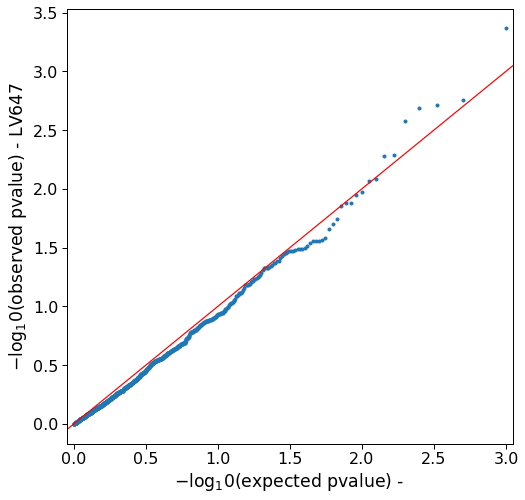

In [227]:
qqplot_unif(results)

**Note**

### Top genes in LV

In [228]:
lv_genes = get_lv_genes(lv_code)
display(lv_genes.head(25))

,LV647,gene_band
SLC44A1,6.254881,9q31.1
UGT8,5.892475,4q26
PIP4K2A,4.575140,10p12.2
CPOX,4.054438,3q11.2
ENPP2,3.832605,8q24.12
SLC12A2,3.772377,5q23.3
QDPR,2.989358,4p15.32
OMG,2.888629,17q11.2
ZFYVE16,2.505029,5q14.1
GNAI1,2.373341,7q21.11


In [229]:
# see bands of top genes
lv_genes.head(25)["gene_band"].value_counts().head(10)

11q22.3     1
3q11.2      1
4p15.32     1
5q23.3      1
2p22.3      1
1q42.13     1
2p21        1
8p21.2      1
13q21.32    1
14q23.3     1
Name: gene_band, dtype: int64

In [230]:
# take a look at all genes with non-zero weight
lv_genes_nonzero_weight = lv_genes[lv_genes[lv_code] > 0]

In [231]:
# how many genes have non-zero weight?
lv_genes_nonzero_weight.shape

(2531, 2)

Similar to LV412

In [232]:
# how are bands distributed among zero weighted genes?
lv_genes_nonzero_weight["gene_band"].value_counts().head(10)

19p13.3     33
16p13.3     24
3p21.31     23
19p13.2     21
17q25.3     20
7q22.1      19
17q11.2     18
16q22.1     18
19q13.12    18
19q13.2     17
Name: gene_band, dtype: int64

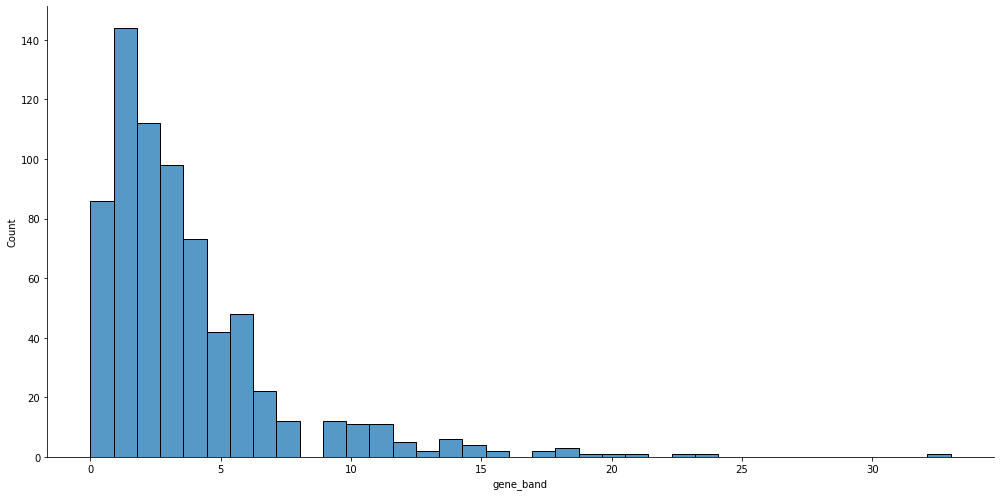

In [233]:
# distribution of amount of bands in LV
g = sns.displot(lv_genes_nonzero_weight["gene_band"].value_counts(), height=7, aspect=2)

Similar to LV412

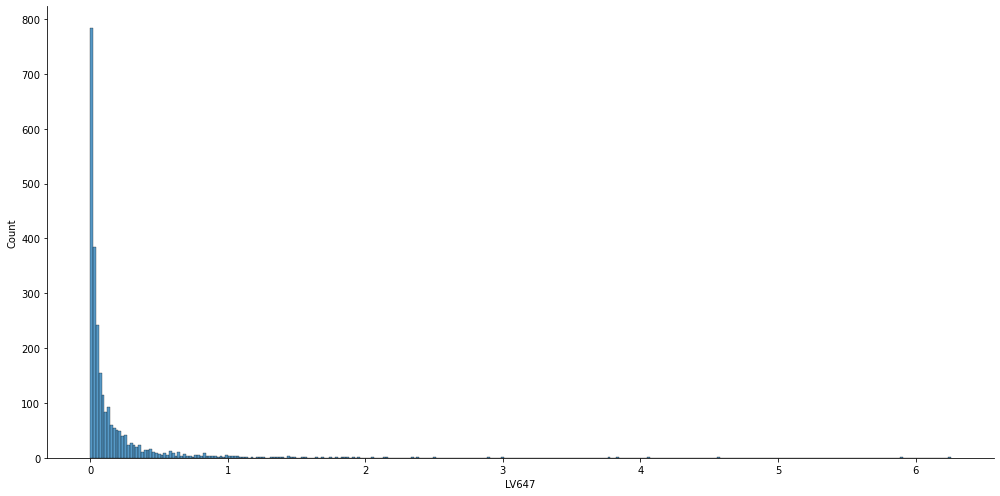

In [234]:
# distribution of weights in LV
g = sns.displot(lv_genes[lv_genes[lv_code] > 0][lv_code], height=7, aspect=2)

More similar to LV57.

### Bottom genes in LV

In [235]:
lv_genes_zero_weight = lv_genes[lv_genes[lv_code] <= 0]

In [236]:
# how many genes have zero weight
lv_genes_zero_weight.shape

(3915, 2)

Compared with LV412, we have more zero weight genes here.

In [237]:
# how are bands distributed among zero weighted genes?
lv_genes_zero_weight["gene_band"].value_counts().head(20)

19p13.3     51
19p13.2     47
16p13.3     46
19q13.2     43
17p13.1     36
19q13.33    34
3p21.31     33
19q13.42    29
14q11.2     28
11q13.1     28
1q21.3      28
16p11.2     26
16q22.1     26
19p13.11    26
12p13.31    26
17q25.3     25
11q13.2     25
12q13.13    24
19q13.43    23
1q23.3      23
Name: gene_band, dtype: int64

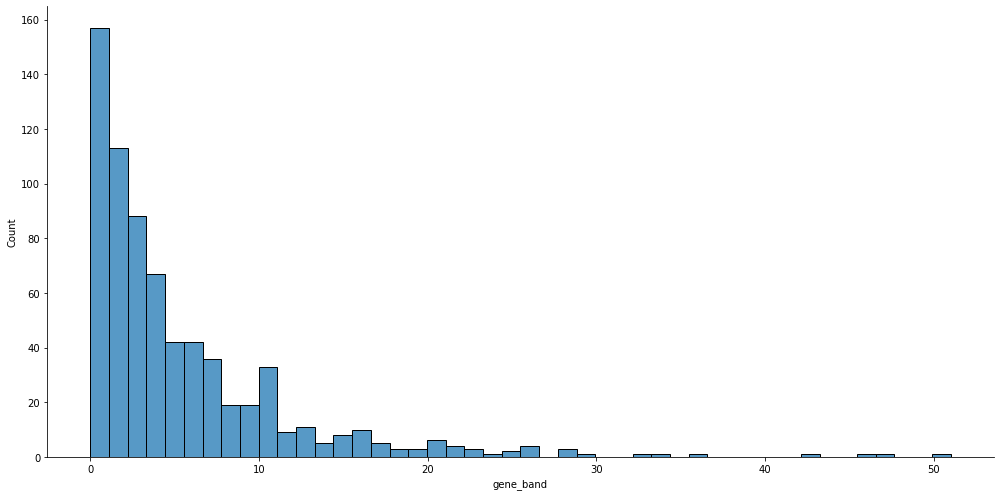

In [238]:
g = sns.displot(lv_genes_zero_weight["gene_band"].value_counts(), height=7, aspect=2)

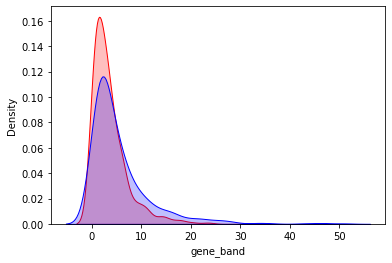

In [239]:
# compare band sizes distribution from top and bottom genes
fig = sns.kdeplot(
    lv_genes_nonzero_weight["gene_band"].value_counts(), shade=True, color="r"
)
fig = sns.kdeplot(
    lv_genes_zero_weight["gene_band"].value_counts(), shade=True, color="b"
)
plt.show()

The distributions of band sizes between zero and non-zero weighted genes in this LV are similar.

# Conclusions

Looks like not-well-calibrated LVs are due to either:
* Too many top genes from the same band.
* Or not matched distributions of band sizes between zero and non-zero weighted genes.
* Too many large bands among the top genes.